Steps to Simulate an X-ray Detector

1. Generate a Photon with a certain electric Polarization, Energy, Incidence Angle and Incidence Point( call that the origin)
2. Once the Photon is "inside" the "detector", simulate the position where it will have its first compton interaction ( pull from an exponential distribution )
3. Once Position of first interaction is known, Use the Klein Nishina Cross section to find the new velocity vector 
4. Find the position of the second interaction, if it happens at all inside the detector, and use compton double counting to create a histogram of the azimuthal angle of scattering.
5. Fit an Acos( phi - phi') + B to those histograms
6. See how the measured polarisation varies with energy of photon and polarisation fraction and absorption coefficient
7. Change to non-perpendicular incidence angles, see if findings change 
8. Compare with actual czti histogramss

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.optimize import curve_fit
import time

print("hello world")
%matplotlib inline

hello world


In [42]:

# Constants
ELECTRON_MASS_ENERGY = 511  # keV

def rotate_vector(vector, theta, phi):
    """
    Rotate a 3D vector by the polar angle (theta) and azimuthal angle (phi).
    
    :param vector: The original vector to rotate.
    :param theta: The polar angle (rotation around y-axis).
    :param phi: The azimuthal angle (rotation around z-axis).
    :return: Rotated vector.
    """
    # Rotation matrix around the z-axis (azimuthal angle, phi)
    R_phi = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi),  0],
        [0,           0,            1]
    ])
    
    # Rotation matrix around the y-axis (polar angle, theta)
    R_theta = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0,             1, 0           ],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    
    # Apply the rotations: first by theta, then by phi
    rotated_vector = np.dot(R_phi, np.dot(R_theta, vector))
    
    return rotated_vector

def generate_photon(energy, polarization, incidence_angle, incidence_point):
    return {
        'energy': energy,
        'polarization': np.array(polarization),
        'direction': np.array([np.sin(incidence_angle[0])*np.cos(incidence_angle[1]), np.sin(incidence_angle[0])*np.sin(incidence_angle[1]), np.cos(incidence_angle[0])]),
        'position': np.array(incidence_point)
    }

def simulate_interaction_position(photon, detector_size):
    attenuation_coeff = 2.64  # cm^-1, example value
    distance = expon.rvs(scale=1/attenuation_coeff)
    new_position = photon['position'] + distance * photon['direction']
    print(f"direction: {photon['direction']}")
    print(f"New position: {new_position}")
    if (-detector_size[0]/2 <= new_position[0] <= detector_size[0]/2 and
        -detector_size[0]/2 <= new_position[1] <= detector_size[1]/2 and
        0 <= new_position[2] <= detector_size[2]):
        return new_position
    return None

import numpy as np

def klein_nishina_cross_section(energy, cos_theta, cos_phi, re=2.817e-13):
    """
    Calculates the Klein-Nishina differential cross-section for Compton scattering of a linearly polarized photon
    in terms of the alpha parameter (ratio of photon energy to electron rest mass energy).
    
    Parameters:
    alpha : float
        The ratio of the incoming photon energy to the electron rest mass energy (E_0 / (m_e c^2)).
    theta : float
        The scattering angle in radians.
    phi : float
        The angle between the polarization direction and the scattering plane in radians.
    re : float, optional
        Classical electron radius (in cm). Default is 2.817e-13 cm.
    
    Returns:
    float
        The differential cross-section in cm²/sr.
    """
    alpha=energy/ELECTRON_MASS_ENERGY
    # Ratio of scattered photon energy to initial photon energy
    epsilon_ratio = 1 / (1 + alpha * (1 -cos_theta))
    
    # Compute the Klein-Nishina differential cross section
    term1 = epsilon_ratio
    term2 = (1 / epsilon_ratio) + epsilon_ratio - 2 * (1-cos_theta**2) * (cos_phi**2)
    
    # Klein-Nishina cross section
    cross_section = 0.5 * re**2 * (term1**2) * term2
    
    return cross_section

def compton_scattering(photon, max_iterations=10000):
    start_time = time.time()
    energy = photon['energy']
    
    # Calculate the maximum value of the Klein-Nishina cross-section for normalization
    theta_values = np.linspace(0, np.pi, 1000)
    phi_values = np.linspace(0, 2*np.pi, 1000)
    cos_theta_values = np.cos(theta_values)
    cos_phi_values = np.cos(phi_values)
    cross_sections = klein_nishina_cross_section(energy, cos_theta_values,cos_phi_values)
    max_cross_section = np.max(cross_sections)
    
    for i in range(max_iterations):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        # Acceptance condition: we use rejection sampling
        if np.random.uniform(0, max_cross_section) < klein_nishina_cross_section(energy, np.cos(theta), np.cos(phi))/max_cross_section:
            break
        else:
            print(f"Warning: Compton scattering did not converge after {max_iterations} iterations")
            return None, None, None
    
    # Calculate new energy
    energy_ratio = 1 / (1 + (energy / ELECTRON_MASS_ENERGY) * (1 - np.cos(theta)))
    new_energy = energy * energy_ratio
    
    new_direction = rotate_vector(photon['direction'], theta, phi)
    
    scattered_photon = photon.copy()
    scattered_photon['energy'] = new_energy
    scattered_photon['direction'] = new_direction
    
    end_time = time.time()
    print(f"Compton scattering time: {end_time - start_time:.4f} seconds")
    print(f"Rejection sampling iterations: {i+1}")
    print(f"Scattering angle (theta): {theta:.4f} radians")
    print(f"Azimuthal angle (phi): {phi:.4f} radians")
    print(f"Energy before: {energy:.2f} keV, Energy after: {new_energy:.2f} keV")
    
    return scattered_photon, theta, phi

def simulate_detector(num_photons, detector_size, initial_energy, polarization, incidence_angle):
    phi_values = []
    
    for i in range(num_photons):
        start_time = time.time()
        print(f"\nSimulating photon {i+1}/{num_photons}")
        
        # Generate photon at the edge of the detector
        initial_position = np.array([0,0,0])
        photon = generate_photon(initial_energy, polarization, incidence_angle, initial_position)
        
        print(f"Initial position: {photon['position']}")
        
        # First interaction
        interaction_pos = simulate_interaction_position(photon, detector_size)
        if interaction_pos is None:
            print(f"Photon escaped without interacting. Final position: {photon['position']}")
            continue
        
        photon['position'] = interaction_pos
        scattered_photon, theta, phi = compton_scattering(photon)
        
        if scattered_photon is None:
            print("Compton scattering failed. Skipping this photon.")
            continue
        
        print(f"First interaction:")
        print(f"  Position: {interaction_pos}")
        print(f"  Scattering angle (θ): {np.degrees(theta):.2f}°")
        print(f"  Azimuthal angle (φ): {np.degrees(phi):.2f}°")
        print(f"  Energy after scattering: {scattered_photon['energy']:.2f} keV")
        
        # Second interaction
        interaction_pos = simulate_interaction_position(scattered_photon, detector_size)
        if interaction_pos is not None:
            phi_values.append(phi)
            print(f"Second interaction:")
            print(f"  Position: {interaction_pos}")
        else:
            print("Photon escaped after first scattering")
        
        end_time = time.time()
        print(f"Total time for this photon: {end_time - start_time:.4f} seconds")
        print("--------------------")
    
    return phi_values



Starting simulation...

Simulating photon 1/10000
Initial position: [0 0 0]
direction: [0. 0. 1.]
New position: [0.         0.         0.62745801]
Compton scattering time: 0.0010 seconds
Rejection sampling iterations: 1
Scattering angle (theta): 1.7517 radians
Azimuthal angle (phi): 2.4561 radians
Energy before: 140.00 keV, Energy after: 105.80 keV
First interaction:
  Position: [0.         0.         0.62745801]
  Scattering angle (θ): 100.37°
  Azimuthal angle (φ): 140.72°
  Energy after scattering: 105.80 keV
direction: [-0.76145831  0.62273038 -0.17996699]
New position: [-0.13991968  0.11442811  0.59438867]
Second interaction:
  Position: [-0.13991968  0.11442811  0.59438867]
Total time for this photon: 0.0010 seconds
--------------------

Simulating photon 2/10000
Initial position: [0 0 0]
direction: [0. 0. 1.]
New position: [0.         0.         0.34985901]
Compton scattering time: 0.0000 seconds
Rejection sampling iterations: 1
Scattering angle (theta): 0.9018 radians
Azimuthal

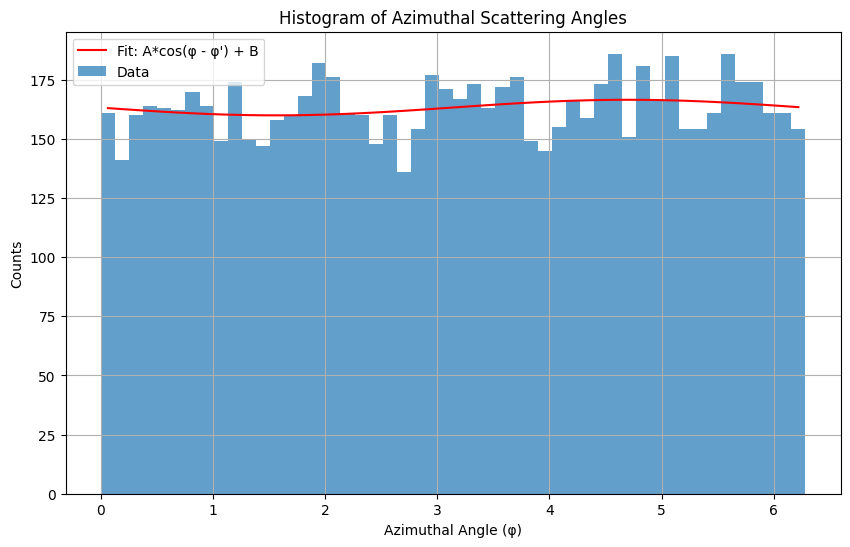

Fit parameters: A = 3.29, B = 163.24, φ' = -1.58


In [43]:
# Main simulation
num_photons = 10000
detector_size = (100, 100, 100)  # cm
initial_energy = 140  # keV
polarization = [1, 0, 0]
incidence_angle = [0,0]  # radians

print("Starting simulation...")
start_time = time.time()
phi_values = simulate_detector(num_photons, detector_size, initial_energy, polarization, incidence_angle)
end_time = time.time()
print(f"Total simulation time: {end_time - start_time:.4f} seconds")
print(phi_values)
# Plotting code (if enough data is collected)
if len(phi_values) > 0:
    hist, bin_edges = np.histogram(phi_values, bins=50, range=(0, 2*np.pi))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def fit_function(phi, A, B, phi_prime):
        return A * np.cos(phi - phi_prime) + B

    try:
        popt, _ = curve_fit(fit_function, bin_centers, hist,p0=[100,100, 0])
        print(popt)
        plt.figure(figsize=(10, 6))
        plt.bar(bin_centers, hist, width=bin_centers[1]-bin_centers[0], alpha=0.7, label='Data')
        plt.plot(bin_centers, fit_function(bin_centers, *popt), 'r-', label='Fit: A*cos(φ - φ\') + B')
        plt.xlabel('Azimuthal Angle (φ)')
        plt.ylabel('Counts')
        plt.title('Histogram of Azimuthal Scattering Angles')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Fit parameters: A = {popt[0]:.2f}, B = {popt[1]:.2f}, φ' = {popt[2]:.2f}")
    except:
        print("Not enough data to perform curve fitting.")
else:
    print("No phi values collected. Unable to create histogram or perform fitting.")